In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../..")

##### Import libary

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, fisher_exact
import utility, importlib
from scipy.stats import spearmanr
import pingouin as pg
from scipy.stats import linregress
import warnings
import kaos
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('mode.chained_assignment', None)
import kaos
import pysam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
# import utility
import importlib
import pandas as pd

pd.set_option('mode.chained_assignment', None)
from pdf2image import convert_from_path
from PIL import Image
from IPython.display import display
# import r_boxplot_utils
import r_plot_utils
import kaos
import fcgr


In [3]:
kmer_length =10
fasta_file_path = "../../../data/GCF_000017985.1_ASM1798v1_genomic.fna"

In [4]:
def strip_whitespace_from_string_columns(input_df):
    """
    Returns a copy of the DataFrame with leading and trailing whitespace removed
    from all string/object columns.
    
    Args:
        input_df (pd.DataFrame): Input DataFrame to process.
    
    Returns:
        pd.DataFrame: Copy with whitespace stripped from all string columns.
    """
    cleaned_df = input_df.copy()
    for column in cleaned_df.select_dtypes(include=['object', 'string']):
        cleaned_df[column] = cleaned_df[column].str.strip()
    return cleaned_df

In [5]:
# LTEE_mutational_data

In [6]:
mutational_data_all_population = pd.read_csv("../../../data/LTEE_mutational_data.csv")
mutational_data_all_population = strip_whitespace_from_string_columns(mutational_data_all_population)


In [7]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

In [8]:
# mutation_with_essentiality_df

In [9]:
df_esm = pd.read_excel("../../../data/LLR.xlsx")
df_esm.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,Start,End,Strand,...,has_space,WT_aa_made2,comparison2,Mut_aa_made,SNP,seq_id_x,universal_id,seq_id_y,mut_name,esm_score
0,241,thrL,A->C,A,C,missense,m1,190,255,+,...,False,MKRISTTITTTITITTGNGAG,True,MKRISTTITTTITITTGHGAG,N18H,241_thrL,241_thrL_N18H,241_thrL,N18H,-4.279933
1,1615,thrA,T->G,T,G,missense,m1,336,2798,+,...,False,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,True,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,I427S,1615_thrA,1615_thrA_I427S,1615_thrA,I427S,-11.530375
2,8430,talB,T->G,T,G,missense,m1,8236,9189,+,...,False,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,True,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,D65E,8430_talB,8430_talB_D65E,8430_talB,D65E,-5.331029
3,12527,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,M123L,12527_dnaK,12527_dnaK_M123L,12527_dnaK,M123L,-4.669276
4,13974,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,Q605P,13974_dnaK,13974_dnaK_Q605P,13974_dnaK,Q605P,-7.992450


In [10]:
df_esm_no_duplicates = df_esm[["Position",  "Gene", "label", "esm_score", "Allele"]].drop_duplicates(subset= ["Position",  "Gene", "label", "Allele"], keep='first')
# df_esm_no_duplicates.dropna(inplace=True)
df_esm_no_duplicates.reset_index(inplace=True, drop=True)
df_esm_no_duplicates = strip_whitespace_from_string_columns(df_esm_no_duplicates)

df_esm_no_duplicates.head()

,Position,Gene,label,esm_score,Allele
0,241,thrL,m1,-4.279933,A->C
1,1615,thrA,m1,-11.530375,T->G
2,8430,talB,m1,-5.331029,T->G
3,12527,dnaK,m1,-4.669276,A->C
4,13974,dnaK,m1,-7.992450,A->C


In [11]:
df_esm_no_duplicates[['REF', 'ALT']] = df_esm_no_duplicates['Allele'].str.split('->', expand=True)
df_esm_no_duplicates = strip_whitespace_from_string_columns(df_esm_no_duplicates)
df_esm_no_duplicates

,Position,Gene,label,esm_score,Allele,REF,ALT
0,241,thrL,m1,-4.279933,A->C,A,C
1,1615,thrA,m1,-11.530375,T->G,T,G
2,8430,talB,m1,-5.331029,T->G,T,G
3,12527,dnaK,m1,-4.669276,A->C,A,C
4,13974,dnaK,m1,-7.992450,A->C,A,C
...,...,...,...,...,...,...,...
18036,4612040,lplA,p6,-8.282178,T->G,T,G
18037,4621500,yjjX,p6,-5.321062,T->G,T,G
18038,4623143,rob,p6,-5.109406,T->G,T,G
18039,4627933,arcA,p6,-4.694204,T->G,T,G


In [12]:
df_esm_no_duplicates.drop_duplicates()

,Position,Gene,label,esm_score,Allele,REF,ALT
0,241,thrL,m1,-4.279933,A->C,A,C
1,1615,thrA,m1,-11.530375,T->G,T,G
2,8430,talB,m1,-5.331029,T->G,T,G
3,12527,dnaK,m1,-4.669276,A->C,A,C
4,13974,dnaK,m1,-7.992450,A->C,A,C
...,...,...,...,...,...,...,...
18036,4612040,lplA,p6,-8.282178,T->G,T,G
18037,4621500,yjjX,p6,-5.321062,T->G,T,G
18038,4623143,rob,p6,-5.109406,T->G,T,G
18039,4627933,arcA,p6,-4.694204,T->G,T,G


In [13]:
# df_esm_no_duplicates.drop_duplicates(subset=["POS", "population_label"])

In [14]:
df_esm_no_duplicates.rename(
        columns={
            "Position": "POS",
            "Gene": "Gene",
            "label":"population_label"
        }, inplace=True
    )


In [15]:
# df_esm_no_duplicates

In [16]:
# df_esm_no_duplicates

In [17]:
# mutation_with_essentiality_df

In [18]:
# all_mutation_with_esm_1b_score_drop_na

In [19]:
# all_mutation_with_esm_1b_score = pd.merge(mutation_with_essentiality_df, df_esm_no_duplicates, how="left")
# all_mutation_with_esm_1b_score_drop_na = all_mutation_with_esm_1b_score.dropna(subset=["esm_score"])    ##### drop the row where esm score is not available
# all_mutation_with_esm_1b_score_drop_na.reset_index(inplace=True, drop=True)
# all_mutation_with_esm_1b_score_drop_na.head()

In [20]:
# all_mutation_with_esm_1b_score_drop_na.drop_duplicates(subset=["unique_mutation_key"])

In [21]:
# all_mutation_with_esm_1b_score_drop_na_unique_mutation = all_mutation_with_esm_1b_score_drop_na.drop_duplicates(subset=["unique_mutation_key"])

In [22]:
# df_esm_no_duplicates

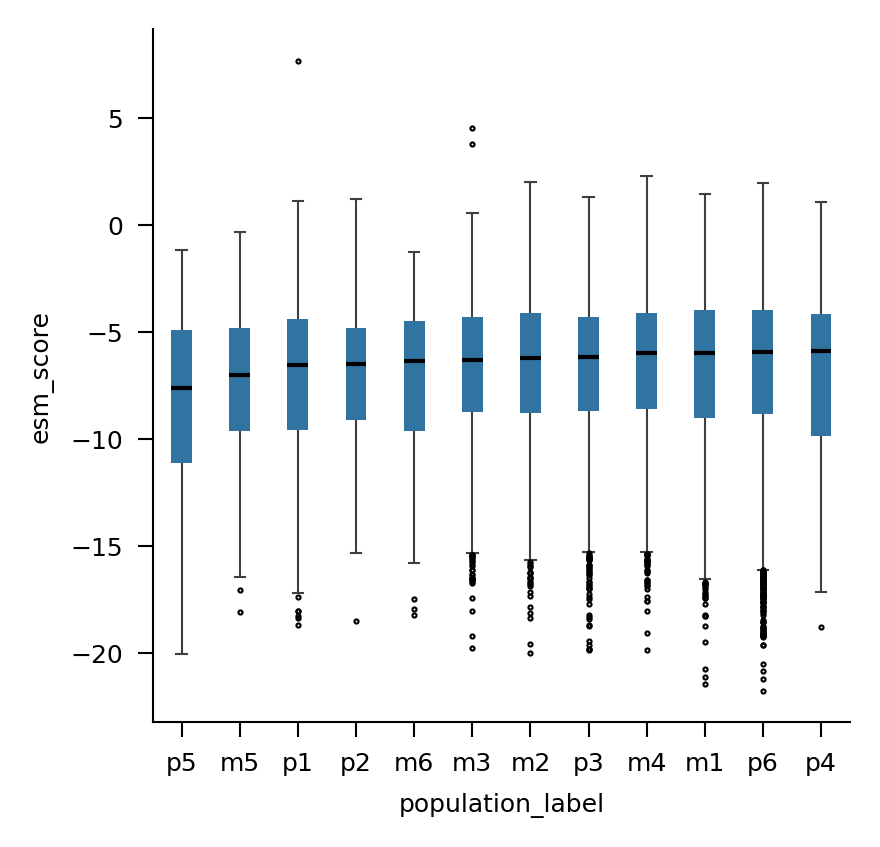

In [23]:
import seaborn as sns
import pandas as pd

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(1, 1, figsize = (3, 3), dpi = 300)
# 1. Compute median of each population_label
median_order = (
    df_esm_no_duplicates
    .groupby("population_label")["esm_score"]
    .median()
    .sort_values()
    .index
)

# 2. Plot boxplot with sorted order
sns.boxplot(
    data=df_esm_no_duplicates,
    x="population_label",
    y="esm_score",
    order=median_order,
    # ax =ax,
    boxprops=dict(edgecolor="black", linewidth=0),ax=ax,flierprops=dict(marker='o', markeredgecolor='black', markersize=0.5), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1
)
ax = utility.custom_figure_axis(ax=ax, rotation=0, fontsize = 6)

plt.savefig("population wise LLR.pdf", dpi = 300)

In [24]:
df_esm_no_duplicates

,POS,Gene,population_label,esm_score,Allele,REF,ALT
0,241,thrL,m1,-4.279933,A->C,A,C
1,1615,thrA,m1,-11.530375,T->G,T,G
2,8430,talB,m1,-5.331029,T->G,T,G
3,12527,dnaK,m1,-4.669276,A->C,A,C
4,13974,dnaK,m1,-7.992450,A->C,A,C
...,...,...,...,...,...,...,...
18036,4612040,lplA,p6,-8.282178,T->G,T,G
18037,4621500,yjjX,p6,-5.321062,T->G,T,G
18038,4623143,rob,p6,-5.109406,T->G,T,G
18039,4627933,arcA,p6,-4.694204,T->G,T,G


In [25]:
p_mut_non_mut = utility.man_whiteney(df_esm_no_duplicates[df_esm_no_duplicates["population_label"].isin(mutator_list)]["esm_score"], df_esm_no_duplicates[df_esm_no_duplicates["population_label"].isin(non_mutator_list)]["esm_score"])
print(f"The one sided p - value between mutator and non- mutator is {p_mut_non_mut}")

The one sided p - value between mutator and non- mutator is 1.564866299688817e-09
